# overview
In this notebook, the objective is to compute receptive field maps for each channel in V1 by analyzing the changes in gamma power relative to the baseline after stimulus onset for each pixel on the screen.

In [9]:
# import libraries
import os
import numpy as np
import pandas as pd
import ast
import gc
import matplotlib.pyplot as plt
import re 
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import sys
sys.path.append('..')
from extraction import get_channels, get_spikes, get_behavior


In [4]:
region = 'VISp'
path_table_info = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/extraction_module/data/eid_probe_info_{region}_{region}.csv'
table = pd.read_csv(path_table_info)
table['pid1'] = table['pid1'].apply(ast.literal_eval)
pids = []
eids = []
for i, row in enumerate(table.iterrows()):
    eid = row[1]['eid']
    pid1 = row[1]['pid1']
    for pid in pid1:
        if os.path.isfile(f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_raw.fif'):
            pids.append(pid)
            eids.append(eid)
print(f'Number of pids with files: {len(pids)} for region {region}')

Number of pids with files: 46 for region VISp


# 1) averaging gamma power after stim 

In [10]:
def rfm_gamma(pid, eid, region):
    from scipy.signal import butter, filtfilt, hilbert
    import numpy as np
    import pandas as pd
    from one.api import ONE
    import brainbox.io.one as bbone
    import brainbox.task.passive as passive
    from brainbox.io.one import SpikeSortingLoader
    import ibldsp.voltage as voltage
    import mne

    def bandpass_filter(lfp_data, low_freq, high_freq, fs):
        nyquist = 0.5 * fs
        low = low_freq / nyquist
        high = high_freq / nyquist
        b, a = butter(2, [low, high], btype='band')
        return filtfilt(b, a, lfp_data, axis=1)

    def compute_gamma_power(lfp_data, fs):
        gamma_band1 = bandpass_filter(lfp_data, 25, 45, fs)
        gamma_band2 = bandpass_filter(lfp_data, 55, 200, fs)
        combined_gamma = gamma_band1 + gamma_band2
        analytic_signal = hilbert(combined_gamma, axis=1)
        gamma_power = np.abs(analytic_signal) ** 2
        return gamma_power

    #################
    # initialize ONE
    #################
    one = ONE(base_url='https://openalyx.internationalbrainlab.org', silent=True)
    one = ONE(password='international')
    ssl = SpikeSortingLoader(pid=pid, one=one)
    
    #################
    # Load channels data 
    #################
    path_channels = f'/mnt/data/AdaptiveControl/IBLrawdata/eid_data/{eid}/probe_{pid}.pkl'
    channels = pd.read_pickle(path_channels)
    pattern = fr'^{region}[12456]$'
    condition = channels['acronym'].str.contains(pattern)
    channels = channels[condition]
    channels = channels[channels['channel_labels'] == 0]
    indices = channels['Unnamed: 0'].values
    ch_coords = channels[['axial_um', 'lateral_um']].to_numpy()
    ch_dist = np.sqrt(np.sum(np.diff(ch_coords, axis=0)**2, axis=1))
    n_channels = len(indices)
    rf_map = np.zeros((15, 15, n_channels-2))

    #################
    # Load passive RF mapping data ( stimulus times, positions, etc. )
    #################
    map = bbone.load_passive_rfmap(eid, one=one)
    RF_frame_times, RF_frame_pos, RF_frame_stim = passive.get_on_off_times_and_positions(map)
    
    # Loop over each stimulus location (x, y) in the 15x15 grid
    for x in range(15):
        for y in range(15):

            #################
            # Extract stimulus times for this pixel
            #################
            pixel_idx = np.bitwise_and(RF_frame_pos[:, 0] == x, RF_frame_pos[:, 1] == y)
            stim_on_frames = RF_frame_stim['on'][pixel_idx]
            stim_on_times = RF_frame_times[stim_on_frames[0][0]]

            gamma_power_responses = []

            for t_event in stim_on_times:

                #################
                # LFP extraction for the stimulus event in passive recording
                #################
                sr_lf = ssl.raw_electrophysiology(band="lf", stream=True)
                sample_lf = int(ssl.samples2times(t_event, direction='reverse') // 12)
                window_secs_ap = [-0.4, 1]

                first, last = (int(window_secs_ap[0] * sr_lf.fs + sample_lf), int(window_secs_ap[1] * sr_lf.fs + sample_lf))
                raw_lf = sr_lf[first:last, :-sr_lf.nsync].T
                
                destriped = voltage.destripe_lfp(raw_lf.astype(float), fs=sr_lf.fs)
                decimated = mne.filter.resample(destriped.astype(float), up=2.0, down=10.0, window='boxcar', npad='auto', pad='reflect_limited', verbose=False)
                decimated = decimated[indices, :] # Select only the channels in the region and less noisy ones

                #################
                # CSD computation
                #################
                v_diff1 = np.diff(decimated[:-1, :], axis=0)
                v_diff2 = np.diff(decimated[1:, :], axis=0)
                ch_dist_mat_expanded = np.tile(ch_dist[:, np.newaxis], (1, decimated.shape[1]))
                csd = (v_diff2 / ch_dist_mat_expanded[1:]) - (v_diff1 / ch_dist_mat_expanded[:-1])
                
                #################
                # Compute gamma power for this stimulus event
                #################
                gamma_power = compute_gamma_power(csd, 500)
                gamma_power_responses.append(gamma_power)


            #################
            # baseline correct gamma power with z-score method ( baseline : 0.4 seconds duration before stimulus onset )
            #################

            # Convert gamma power responses to an array
            gamma_power_array = np.array(gamma_power_responses)
            # Compute baseline mean and std for z-score calculation
            baseline_duration = int(0.4 * 500)  # 0.4 seconds
            after_stim_duration = int(1.0 * 500)  # 1 second
            baseline_means = np.mean(gamma_power_array[:, :, :baseline_duration], axis=2)
            baseline_stds = np.std(gamma_power_array[:, :, :baseline_duration], axis=2)
            # Compute z-scores for 1 second after stimulus
            after_stim_gamma_power = gamma_power_array[:, :, baseline_duration:baseline_duration + after_stim_duration]
            z_scores = (np.mean(after_stim_gamma_power, axis=2) - baseline_means) / baseline_stds
            mean_z_scores = np.mean(z_scores, axis=0) # Average z-scores across stimulus events (approximately 8 to 12 events 'on' per pixel)
            #################
            # Save RF map
            #################
            rf_map[x, y, :] = mean_z_scores  

    # Save RF map 
    np.save(f'rf_map_{pid}_csd_zscore_gamma.npy', rf_map)
    return


In [11]:
joblist = []
executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=24, timeout_min=300, slurm_partition="CPU", cpus_per_task=5, slurm_comment='compute_epochTFR')
# Submit jobs
for i, (pid, eid) in enumerate(zip(pids, eids)):
    if i >0:
        break
    job = executor.submit(rfm_gamma, pid, eid, 'VISp')
    job.job_initial_indice = i
    joblist.append(job)

# Monitor jobs
clean_jobs_live = False
finished_list, finished_order = [], []

print('#### Start waiting for jobs to return #####')
while joblist:
    for i, job in enumerate(joblist):
        if job.done():
            print(f"{len(finished_list)+1} on {len(joblist)}")
            print(f"last job finished: {job.job_id}")
            if clean_jobs_live:
                del job
                gc.collect()
            else:
                finished_list.append(job)
                finished_order.append(job.job_initial_indice)
            joblist.pop(i)
            break

print('#### All jobs completed #####')
print('#### you can start plotting the result #####')

#### Start waiting for jobs to return #####
1 on 1
last job finished: 45182
#### All jobs completed #####
#### you can start plotting the result #####


## plotting the result

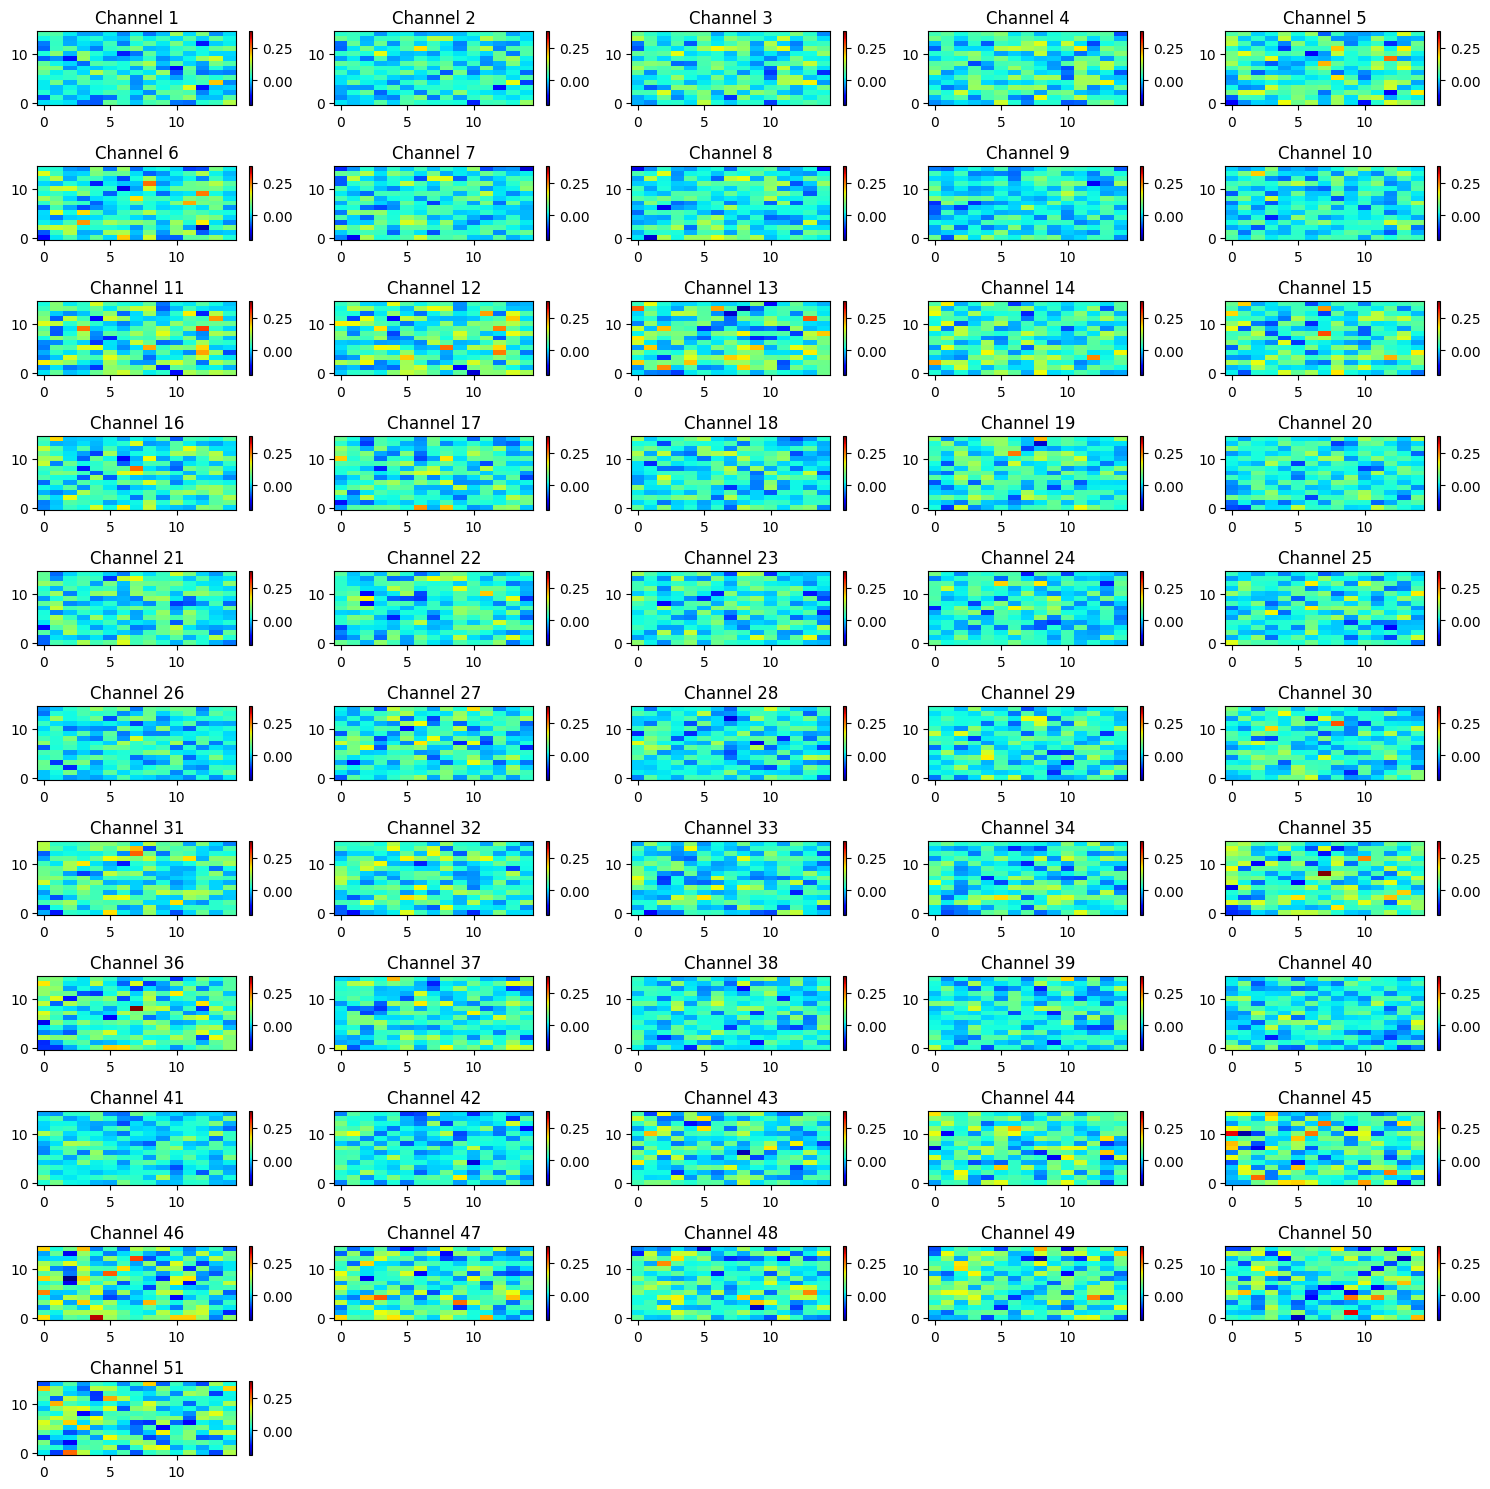

In [14]:


import numpy as np
import matplotlib.pyplot as plt

pid = pids[0]
path = f'rf_map_{pid}_gamma.npy'
data = np.load(path)
n_channels = data.shape[2]  # Updated to get the number of channels from the new RF map shape

# Determine global min and max values for the color scale
vmin = np.min(data)
vmax = np.max(data)

# Plot all channels
n_plots = n_channels
fig, axes = plt.subplots(int(np.ceil(n_plots / 5)), 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(n_channels):
    im = axes[i].imshow(data[:, :, i], aspect='auto', cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
    fig.colorbar(im, ax=axes[i])
    axes[i].set_title(f'Channel {i + 1}')  # Adding titles for each subplot

# Remove any empty subplots
for ax in axes[n_channels:]:
    ax.remove()

plt.tight_layout()
plt.show()


### masking the pixles with z score power change less than threshold

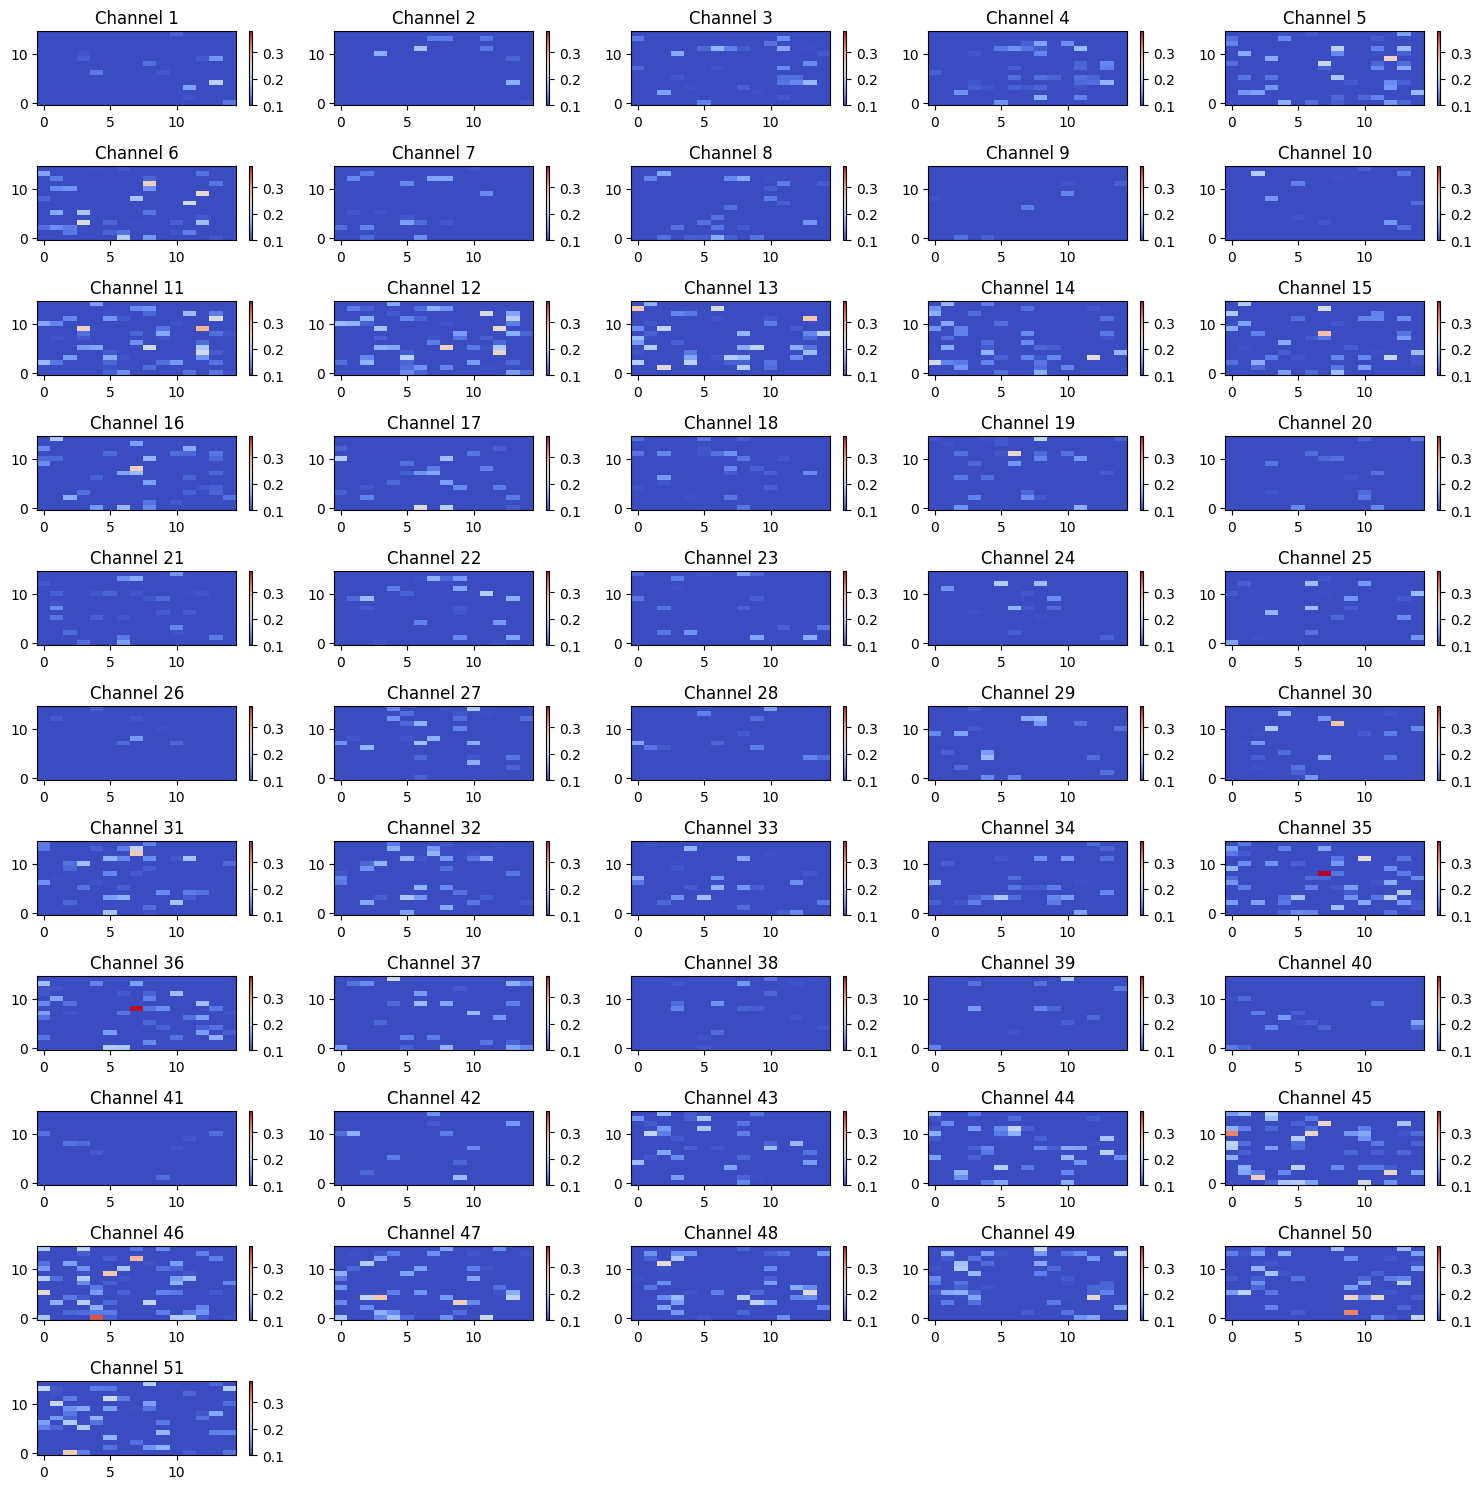

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

pid = pids[0]
path = f'rf_map_{pid}_gamma.npy'

data = np.load(path)
n_channels = data.shape[2]  # Updated to get the number of channels from the new RF map shape

# Set the threshold
threshold = 0.1

# Create a custom colormap that transitions from blue to warm (red)
cmap = plt.cm.coolwarm  # Using the 'coolwarm' colormap

# Determine global min and max values for the color scale
vmin = np.min(data)
vmax = np.max(data)

# Plot all channels
n_plots = n_channels
fig, axes = plt.subplots(int(np.ceil(n_plots / 5)), 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(n_channels):
    im = axes[i].imshow(data[:, :, i], aspect='auto', cmap=cmap, origin='lower', vmin=threshold, vmax=vmax)
    
    fig.colorbar(im, ax=axes[i])
    axes[i].set_title(f'Channel {i + 1}')  # Adding titles for each subplot

    # Masking values below the threshold
    im.set_clim(threshold, vmax)  # Set color limits to show under threshold as the colormap's lower color

# Remove any empty subplots
for ax in axes[n_channels:]:
    ax.remove()

plt.tight_layout()
plt.show()



# 2) binning after stimulus and use SVD 
this binning and using SVD is adopted from IBL_example for computing RFM based on spikes


In [15]:
def rfm_gamma(pid, eid, region):
    from scipy.signal import butter, filtfilt, hilbert
    import numpy as np
    import pandas as pd
    from one.api import ONE
    import brainbox.io.one as bbone
    import brainbox.task.passive as passive
    from brainbox.io.one import SpikeSortingLoader
    import ibldsp.voltage as voltage
    import mne

    def bandpass_filter(lfp_data, low_freq, high_freq, fs):
        nyquist = 0.5 * fs
        low = low_freq / nyquist
        high = high_freq / nyquist
        b, a = butter(2, [low, high], btype='band')
        return filtfilt(b, a, lfp_data, axis=1)

    def compute_gamma_power(lfp_data, fs):
        gamma_band1 = bandpass_filter(lfp_data, 25, 45, fs)
        gamma_band2 = bandpass_filter(lfp_data, 55, 200, fs)
        combined_gamma = gamma_band1 + gamma_band2
        analytic_signal = hilbert(combined_gamma, axis=1)
        gamma_power = np.abs(analytic_signal) ** 2
        return gamma_power

    one = ONE(base_url='https://openalyx.internationalbrainlab.org', silent=True)
    one = ONE(password='international')

    ssl = SpikeSortingLoader(pid=pid, one=one)
    path_channels = f'/mnt/data/AdaptiveControl/IBLrawdata/eid_data/{eid}/probe_{pid}.pkl'
    channels = pd.read_pickle(path_channels)

    pattern = fr'^{region}[12456]$'
    condition = channels['acronym'].str.contains(pattern)
    channels = channels[condition]
    channels = channels[channels['channel_labels'] == 0]
    indices = channels['Unnamed: 0'].values
    ch_coords = channels[['axial_um', 'lateral_um']].to_numpy()
    ch_dist = np.sqrt(np.sum(np.diff(ch_coords, axis=0)**2, axis=1))

    n_channels = len(indices)
    rf_map = np.zeros((15, 15, n_channels-2))
    map = bbone.load_passive_rfmap(eid, one=one)

    RF_frame_times, RF_frame_pos, RF_frame_stim = passive.get_on_off_times_and_positions(map)

    # Parameters for binning
    after_stim_duration = 1.0  # 1 second
    bin_size = 0.1  # 100 ms bins
    n_bins = int(after_stim_duration / bin_size)  # Number of bins in the 1 second after stimulus

    # Loop over each stimulus location (x, y) in the 15x15 grid
    for x in range(15):
        for y in range(15):
            #################
            # Extract stimulus times for this pixel
            #################
            pixel_idx = np.bitwise_and(RF_frame_pos[:, 0] == x, RF_frame_pos[:, 1] == y)
            stim_on_frames = RF_frame_stim['on'][pixel_idx]
            stim_on_times = RF_frame_times[stim_on_frames[0][0]]

            gamma_power_responses = []

            for t_event in stim_on_times:
                #################
                # LFP extraction for the stimulus event in passive recording
                #################
                sr_lf = ssl.raw_electrophysiology(band="lf", stream=True)
                sample_lf = int(ssl.samples2times(t_event, direction='reverse') // 12)
                window_secs_ap = [-0.4, 1]

                first, last = (int(window_secs_ap[0] * sr_lf.fs + sample_lf), int(window_secs_ap[1] * sr_lf.fs + sample_lf))
                raw_lf = sr_lf[first:last, :-sr_lf.nsync].T
                
                destriped = voltage.destripe_lfp(raw_lf.astype(float), fs=sr_lf.fs)
                decimated = mne.filter.resample(destriped.astype(float), up=2.0, down=10.0, window='boxcar', npad='auto', pad='reflect_limited', verbose=False)
                decimated = decimated[indices, :]  # Select only the channels in the region and less noisy ones

                #################
                # CSD computation
                #################
                v_diff1 = np.diff(decimated[:-1, :], axis=0)
                v_diff2 = np.diff(decimated[1:, :], axis=0)
                ch_dist_mat_expanded = np.tile(ch_dist[:, np.newaxis], (1, decimated.shape[1]))
                csd = (v_diff2 / ch_dist_mat_expanded[1:]) - (v_diff1 / ch_dist_mat_expanded[:-1])
                
                #################
                # Compute gamma power for this stimulus event
                #################
                gamma_power = compute_gamma_power(csd, 500)
                gamma_power_responses.append(gamma_power)

            #################
            # Compute binned gamma power responses
            #################
            gamma_power_array = np.array(gamma_power_responses)
            baseline_duration = int(0.4 * 500)  # 0.4 seconds
            after_stim_duration = int(1.0 * 500)  # 1 second

            # Binning the gamma power responses
            binned_gamma_power = np.zeros((gamma_power_array.shape[0], n_channels-2, n_bins))

            for i in range(gamma_power_array.shape[0]):
                for ch in range(n_channels-2):
                    for bin_idx in range(n_bins):
                        start_idx = baseline_duration + int(bin_idx * bin_size * 500)
                        end_idx = baseline_duration + int((bin_idx + 1) * bin_size * 500)
                        binned_gamma_power[i, ch, bin_idx] = np.mean(gamma_power_array[i, ch, start_idx:end_idx])

            #################
            # Apply SVD on the binned gamma power
            #################
            binned_gamma_power_mean = np.mean(binned_gamma_power, axis=0)  # Average over trials
            u, s, v = np.linalg.svd(binned_gamma_power_mean - np.mean(binned_gamma_power_mean, axis=1, keepdims=True), full_matrices=False)

            #################
            # Save RF map
            #################
            rf_map[x, y, :] = u[:, 0] * s[0]  # Store the first spatial component

    # Save RF map 
    np.save(f'rf_map_{pid}_svd_gamma.npy', rf_map)
    return


In [ ]:
joblist = []
executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=24, timeout_min=300, slurm_partition="CPU", cpus_per_task=5, slurm_comment='compute_epochTFR')
# Submit jobs
for i, (pid, eid) in enumerate(zip(pids, eids)):
    if i >0:
        break
    job = executor.submit(rfm_gamma, pid, eid, 'VISp')
    job.job_initial_indice = i
    joblist.append(job)

# Monitor jobs
clean_jobs_live = False
finished_list, finished_order = [], []

print('#### Start waiting for jobs to return #####')
while joblist:
    for i, job in enumerate(joblist):
        if job.done():
            print(f"{len(finished_list)+1} on {len(joblist)}")
            print(f"last job finished: {job.job_id}")
            if clean_jobs_live:
                del job
                gc.collect()
            else:
                finished_list.append(job)
                finished_order.append(job.job_initial_indice)
            joblist.pop(i)
            break

print('#### All jobs completed #####')
print('#### you can start plotting the result #####')

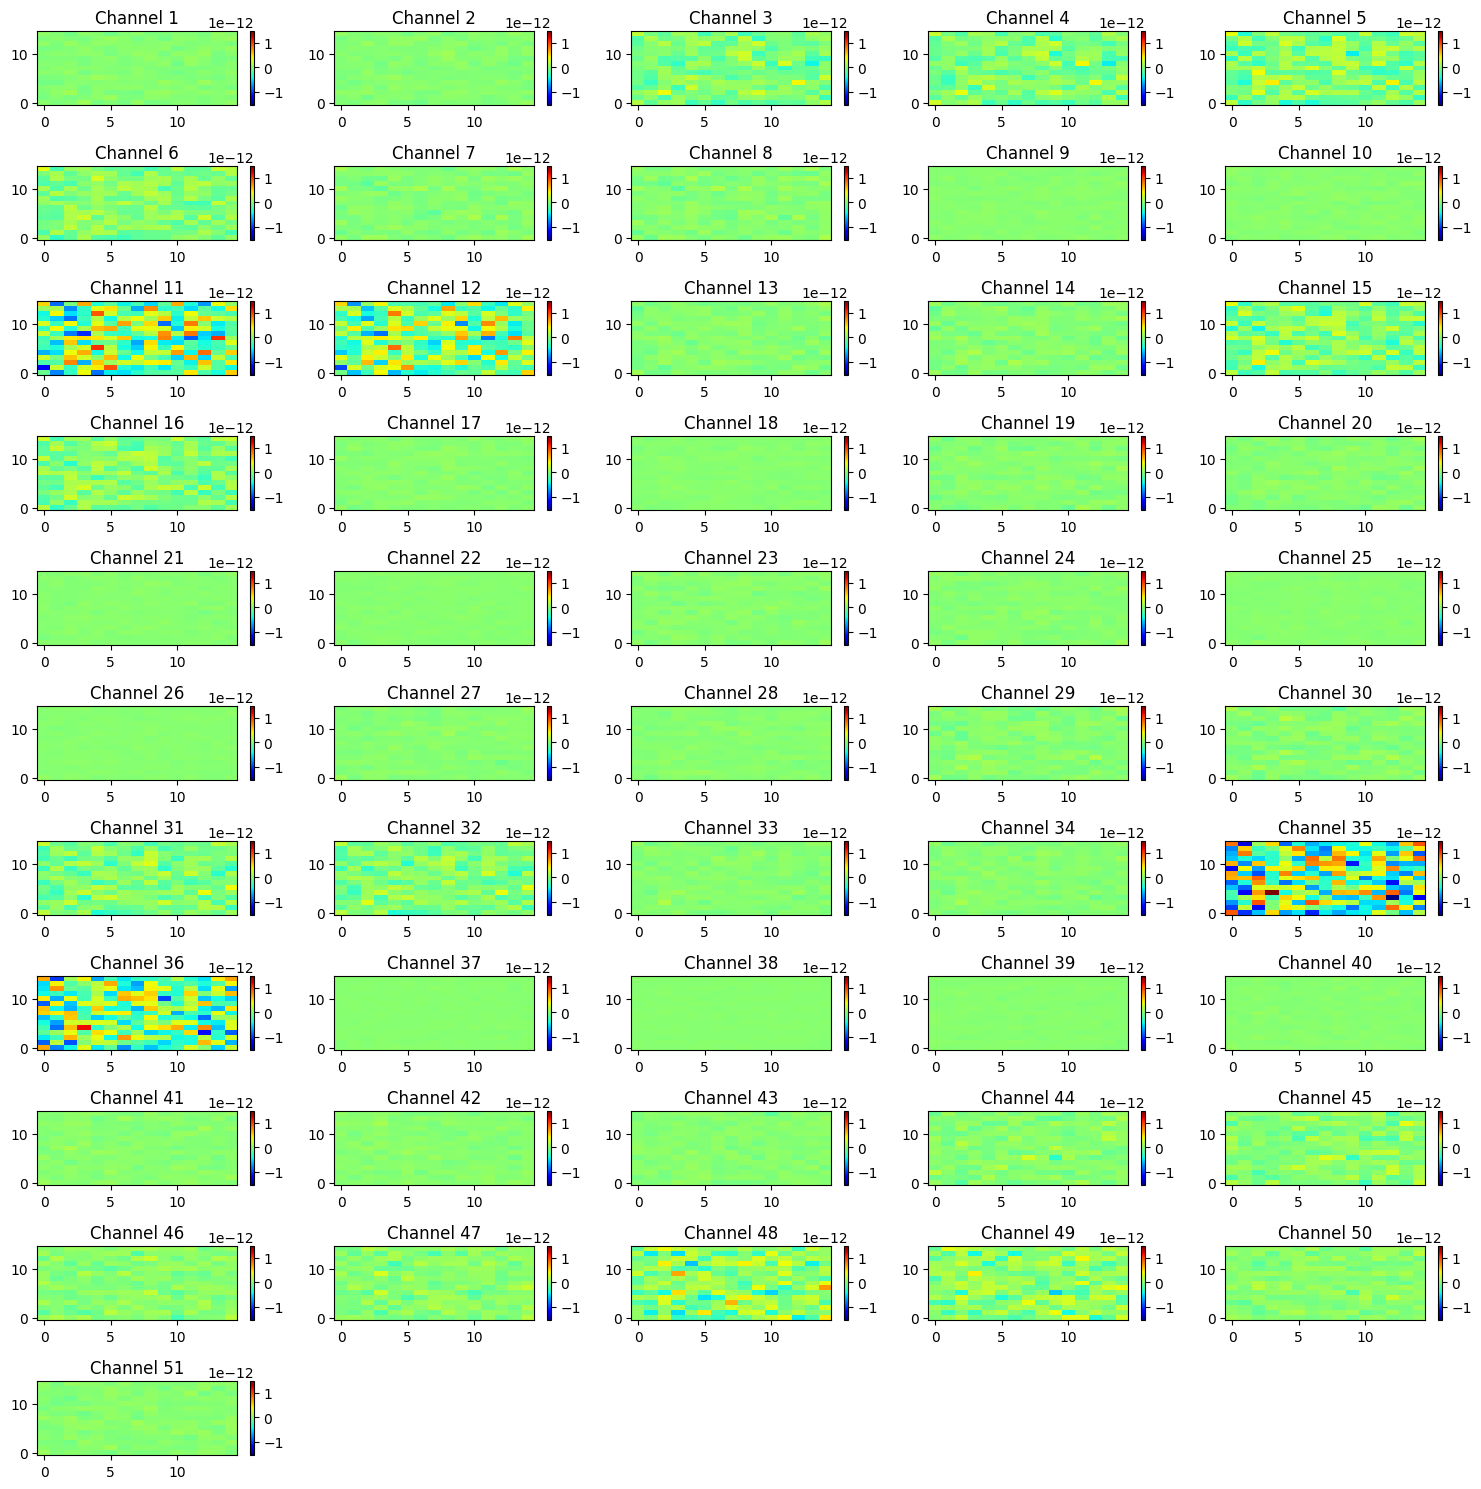

In [9]:


import numpy as np
import matplotlib.pyplot as plt

pid = pids[0]
path = f'rf_map_{pid}_svd_gamma.npy'
data = np.load(path)
n_channels = data.shape[2]  # Updated to get the number of channels from the new RF map shape

# Determine global min and max values for the color scale
vmin = np.min(data)
vmax = np.max(data)

# Plot all channels
n_plots = n_channels
fig, axes = plt.subplots(int(np.ceil(n_plots / 5)), 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(n_channels):
    im = axes[i].imshow(data[:, :, i], aspect='auto', cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
    fig.colorbar(im, ax=axes[i])
    axes[i].set_title(f'Channel {i + 1}')  # Adding titles for each subplot

# Remove any empty subplots
for ax in axes[n_channels:]:
    ax.remove()

plt.tight_layout()
plt.show()
